In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re
import os
import shutil
import json

In [2]:
import numpy as np
import pickle as pkl
import pandas as pd
from sklearn import metrics
import tensorflow as tf

In [3]:
from PIL import Image

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 9, 9
plt.rcParams.update({'font.size': 24})

In [5]:
# This is required for me to have autocomplete
%config Completer.use_jedi = False
%matplotlib inline

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [7]:
# auxillary functions for frequency-weighted IoU
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

In [8]:
# frequency-weighted IoU
def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

In [9]:
# array path
array_path = "data/testset/final_arrays/"

# evaluation path
eval_path = "data/testset/evaluation/"

# dataset sizes (for looping)
sizes = ["small","medium","large","small_transform","medium_transform","large_transform"]

# models
models = ["Vanilla8",
          "Vanilla32",
          "VGG8",
          "VGG32",
          "Restnet8",
          "Restnet32",
          "VanillaUnet",
          "Resnet50Unet"]

## Load data for testing

In [178]:
#load ground truth
with open(array_path+'annotations.pickle', 'rb') as handle:
    ann = pkl.load(handle)

In [24]:
with open(array_path+"Vanilla8"+"_"+"small"+'.pickle', 'rb') as handle:
    pred = pkl.load(handle)

In [25]:
# visual test
arr_1 = ann["22446.png"]
arr_gf = arr_1*100
zeros = np.zeros((800,800))
testg = np.dstack((zeros,zeros,arr_gf))
cv2.imwrite("data/testset/testann.png", testg)

arr_2 = pred["22446.png"]
arr_pf = arr_2*100
zeros = np.zeros((800,800))
test = np.dstack((zeros,zeros,arr_pf))
cv2.imwrite("data/testset/testpred.png", test)

True

## Calculate base metrics (image level)

In [185]:
# calculate relevant overlapping metrics
calculation_dict = {}
            
for model in models:
    for size in sizes:
        
        # set lists for pandas dataframe
        image_name = []
        total_pix = []
        zebra_pix = []
        back_pix = []
        M_IoU = []
        freq_M_IoU = []
        TP = []
        FN = []
        FP = []
        TN = []
        
        array_dir = array_path+model+"_"+size+'.pickle'
        print(array_dir)
        
        # load predictions
        with open(array_path+model+"_"+size+'.pickle', 'rb') as handle:
            pred = pkl.load(handle)
        
        for name in ann.keys():
            
            # set matrixes
            arr_g = ann[name]
            arr_p = pred[name]
            arr_g_flip = np.where(arr_g == 0,1,0)
            arr_p_flip = np.where(arr_p == 0,1,0)
            
            # calculate IoU
            m = tf.keras.metrics.MeanIoU(num_classes=2)
            m.update_state(arr_g, arr_p)
            iou = m.result().numpy()
            
            # Calculate frequency-weighted IoU
            freq_iou = frequency_weighted_IU(arr_p, arr_g)
            
            # Append to lists
            image_name.append(name)
            total_pix.append(arr_g.shape[0]*arr_g.shape[1])
            zebra_pix.append(np.sum(arr_g))
            back_pix.append(np.sum(arr_g == 0))
            M_IoU.append(iou)
            freq_M_IoU.append(freq_iou)
            TP.append(np.sum((arr_g*arr_p) == 1))
            FN.append(np.sum(arr_g > arr_p))
            FP.append(np.sum(arr_g < arr_p))
            TN.append(np.sum((arr_g_flip*arr_p_flip) == 1))
            
            
            # create final dataframe
            df = pd.DataFrame({"image_name":image_name,
                              "total_pix":total_pix,
                              "zebra_pix": zebra_pix,
                              "back_pix": back_pix,
                               "M_IoU": M_IoU,
                               "freq_M_IoU": freq_M_IoU,
                              "TP":TP,
                              "FN":FN,
                              "FP":FP,
                              "TN":TN})
                      
            calculation_dict[model+"_"+size] = df

data/testset/final_arrays/Vanilla8_small.pickle
data/testset/final_arrays/Vanilla8_medium.pickle
data/testset/final_arrays/Vanilla8_large.pickle
data/testset/final_arrays/Vanilla8_small_transform.pickle
data/testset/final_arrays/Vanilla8_medium_transform.pickle
data/testset/final_arrays/Vanilla8_large_transform.pickle
data/testset/final_arrays/Vanilla32_small.pickle
data/testset/final_arrays/Vanilla32_medium.pickle
data/testset/final_arrays/Vanilla32_large.pickle
data/testset/final_arrays/Vanilla32_small_transform.pickle
data/testset/final_arrays/Vanilla32_medium_transform.pickle
data/testset/final_arrays/Vanilla32_large_transform.pickle
data/testset/final_arrays/VGG8_small.pickle
data/testset/final_arrays/VGG8_medium.pickle
data/testset/final_arrays/VGG8_large.pickle
data/testset/final_arrays/VGG8_small_transform.pickle
data/testset/final_arrays/VGG8_medium_transform.pickle
data/testset/final_arrays/VGG8_large_transform.pickle
data/testset/final_arrays/VGG32_small.pickle
data/testset/

In [186]:
smallest_zebra = np.min(calculation_dict["Vanilla8_small"]["zebra_pix"].loc[calculation_dict["Vanilla8_small"]["zebra_pix"] > 0])

In [218]:
smallest_zebra

2013

## Calculate extra metrics (image level)

In [187]:
# Extra calculations
calculation_dict2 = {}

for name in calculation_dict.keys():
    df = calculation_dict[name]
    
    df["positive"] = df["zebra_pix"] > 0
    df["pixel_acc"] = (df["TP"]+df["TN"])/df["total_pix"]
    df["mean_acc"] = (1/2)*((df["TP"]/df["zebra_pix"])+(df["TN"]/df["back_pix"]))
    df["dice"] = ((2*df["TP"])/(df["total_pix"]*2)+(2*df["TN"])/(df["total_pix"]*2))/2
    df["pix_precision"] = df["TP"]/(df["TP"]+df["FP"])
    df["pix_recall"] = df["TP"]/(df["TP"]+df["FN"])
    df["F1"] = 2*((df["pix_precision"]*df["pix_recall"])/(df["pix_precision"]+df["pix_recall"]))
    df["False_pos"] = (df["FP"] > smallest_zebra) & (df["positive"] == 0)
    df["False_neg"] = (df["TP"] == 0) & (df["positive"] == 1)
    
    calculation_dict2[name] = df

In [188]:
# save dict
with open(eval_path+'evaluation_dict.pickle', 'wb') as handle:
    pkl.dump(calculation_dict2, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Find false positive/ false negative images

In [189]:
false_pos = []

for name in calculation_dict2.keys():
    df = calculation_dict2[name]
    
    df_filter = df.loc[df["False_pos"] == True]
    
    false_pos.append(df_filter)
    
false_pos = pd.concat(false_pos)
false_pos = false_pos["image_name"]
false_pos = false_pos.value_counts().rename_axis('image').reset_index(name='counts')
false_pos

,image,counts
0,negset_11136.png,30
1,negset_19773.png,13
2,negset_14855.png,12
3,negset_3606.png,5
4,negset_14551.png,5
5,negset_7503.png,4
6,negset_13743.png,4
7,negset_18337.png,4
8,negset_5207.png,3
9,negset_11077.png,2


In [190]:
false_negs = []

for name in calculation_dict2.keys():
    df = calculation_dict2[name]
    
    df_filter = df.loc[df["False_neg"] == True]
    
    false_negs.append(df_filter)

false_negs = pd.concat(false_negs)
false_negs = false_negs["image_name"]
false_negs = false_negs.value_counts().rename_axis('image').reset_index(name='counts')
false_negs

,image,counts
0,22421.png,32
1,32611.png,19
2,32590.png,17
3,34423.png,16
4,32572.png,15
...,...,...
245,34190.png,3
246,43548.png,3
247,21972.png,3
248,38340.png,3


In [191]:
false_neg_list = [false_pos, false_negs]

names = ["false_pos", "false_negs"]
writer=pd.ExcelWriter(r"data/testset/evaluation/pos_negs.xlsx")
for i, A in enumerate(false_neg_list):
    A.to_excel(writer,sheet_name="{0}".format(names[i]))

writer.save()

### To-do:

- for each model + dataset, over all positive images:
 1. Mean pixel accuracy
 2. Mean IoU
 3. Frequency-weighted IoU
 4. Mean Dice
 5. Mean Recall
 6. Mean Precision
     
     
- and over all negative images:
 1. number of false-positives
 2. number of false-negatives

## Calculate base metrics (dataset level)

In [12]:
# load dict
with open(eval_path+'evaluation_dict.pickle', 'rb') as handle:
    calculation_dict2 = pkl.load(handle)

In [17]:
calculation_dict2.keys()

dict_keys(['Vanilla8_small', 'Vanilla8_medium', 'Vanilla8_large', 'Vanilla8_small_transform', 'Vanilla8_medium_transform', 'Vanilla8_large_transform', 'Vanilla32_small', 'Vanilla32_medium', 'Vanilla32_large', 'Vanilla32_small_transform', 'Vanilla32_medium_transform', 'Vanilla32_large_transform', 'VGG8_small', 'VGG8_medium', 'VGG8_large', 'VGG8_small_transform', 'VGG8_medium_transform', 'VGG8_large_transform', 'VGG32_small', 'VGG32_medium', 'VGG32_large', 'VGG32_small_transform', 'VGG32_medium_transform', 'VGG32_large_transform', 'Restnet8_small', 'Restnet8_medium', 'Restnet8_large', 'Restnet8_small_transform', 'Restnet8_medium_transform', 'Restnet8_large_transform', 'Restnet32_small', 'Restnet32_medium', 'Restnet32_large', 'Restnet32_small_transform', 'Restnet32_medium_transform', 'Restnet32_large_transform', 'VanillaUnet_small', 'VanillaUnet_medium', 'VanillaUnet_large', 'VanillaUnet_small_transform', 'VanillaUnet_medium_transform', 'VanillaUnet_large_transform', 'Resnet50Unet_small',

In [18]:
# set lists
full_model_name = []
model_name = []
data_size = []
mean_pix_acc = []
mean_acc = []
mean_iou = []
mean_F_iou = []
mean_dice = []
mean_pix_recall = []
mean_pix_precision = []
perc_false_pos = []
perc_false_negs = []

for name in calculation_dict2.keys():
    
    df = calculation_dict2[name]

    # get all the positive images
    df_neg = df[df['image_name'].str.contains("negset")]
    df = df[~df['image_name'].str.contains("negset")]
    
    # correct name
    if "Restnet" in name:
        name = re.sub('Restnet',"Resnet",name)
    else:
        name = name

    full_model_name.append(name)
    model_name.append(re.search("^.{3,15}?(?=\_)",name).group(0))
    data_size.append(re.search("(?<=\_).*",name).group(0))
    mean_pix_acc.append(df["pixel_acc"].mean())
    mean_acc.append(df["mean_acc"].mean())
    mean_iou.append(df["M_IoU"].mean())
    mean_F_iou.append(df["freq_M_IoU"].mean())
    mean_dice.append(df["dice"].mean())
    mean_pix_recall.append(df["pix_recall"].mean())
    mean_pix_precision.append(df["pix_precision"].mean())
    perc_false_pos.append((sum(df_neg["False_pos"] == True) / (df_neg.shape[0]/2)*100))
    perc_false_negs.append((sum(df["False_neg"] == True) / (df.shape[0]/2)*100))

    
# Get final model
model_df = pd.DataFrame({"full_model_name":full_model_name,
                         "model_name": model_name,
                         "data_size": data_size,
                         "mean_pix_acc":mean_pix_acc,
                         "mean_acc": mean_acc,
                         "mean_iou":mean_iou,
                         "mean_F_iou":mean_F_iou,
                         "mean_dice":mean_dice,
                         "mean_pix_recall":mean_pix_recall,
                         "mean_pix_precision":mean_pix_precision,
                         "perc_false_pos":perc_false_pos,
                         "perc_false_negs":perc_false_negs})

In [19]:
## Some string cleanup
# round model
model_df = model_df.round(3)

#model_df['data_size_name'] = model_df['data_size'].str.replace("_", " ")
#model_df['data_size_name'] = model_df['data_size_name'].str.replace("form", "formed")

# set categorical order
model_df['data_size'] = pd.Categorical(model_df['data_size'],
                                   categories=['small', 'medium', 'large', 
                                               'small_transform','medium_transform','large_transform'],
                                   ordered=True)

In [20]:
model_df["model_name"] = model_df["model_name"].str.replace("50","")

In [21]:
## Filter VGG
model_df = model_df[~model_df['model_name'].str.contains("VGG")]

In [303]:
# save dict
with open(eval_path+'model_evaluation_dict.pickle', 'wb') as handle:
    pkl.dump(model_df, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [10]:
# load dict
with open(eval_path+'evaluation_dict.pickle', 'rb') as handle:
    model_df = pkl.load(handle)

## Find false positive/ false negative images

In [22]:
false_pos = []

for name in calculation_dict2.keys():
    
    if "VGG" not in name:
        continue
    
    df = calculation_dict2[name]
    
    df_filter = df.loc[df["False_pos"] == True]
    
    false_pos.append(df_filter)
    
false_pos = pd.concat(false_pos)
false_pos = false_pos["image_name"]
false_pos = false_pos.value_counts().rename_axis('image').reset_index(name='counts')
false_pos

,image,counts
0,negset_19773.png,8
1,negset_11136.png,7
2,negset_7503.png,2
3,negset_14551.png,2
4,negset_14855.png,2
5,negset_29397.png,1
6,negset_7339.png,1
7,negset_15023.png,1
8,negset_13434.png,1
9,negset_26543.png,1


In [23]:
false_negs = []

for name in calculation_dict2.keys():
    df = calculation_dict2[name]
    
    if "VGG" not in name:
        continue
    
    df_filter = df.loc[df["False_neg"] == True]
    
    false_negs.append(df_filter)

false_negs = pd.concat(false_negs)
false_negs = false_negs["image_name"]
false_negs = false_negs.value_counts().rename_axis('image').reset_index(name='counts')
false_negs

,image,counts
0,22421.png,11
1,32590.png,7
2,31805.png,6
3,34423.png,6
4,29268.png,6
...,...,...
245,38320.png,3
246,43542.png,3
247,22428.png,3
248,29963.png,3


In [24]:
false_neg_list = [false_pos, false_negs]

names = ["false_pos", "false_negs"]
writer=pd.ExcelWriter(r"data/testset/evaluation/pos_negs.xlsx")
for i, A in enumerate(false_neg_list):
    A.to_excel(writer,sheet_name="{0}".format(names[i]))

writer.save()

In [25]:
model_df.sort_values(by = "mean_F_iou", ascending=False)

,full_model_name,model_name,data_size,mean_pix_acc,mean_acc,mean_iou,mean_F_iou,mean_dice,mean_pix_recall,mean_pix_precision,perc_false_pos,perc_false_negs
41,VanillaUnet_large_transform,VanillaUnet,large_transform,0.997,0.959,0.917,0.995,0.499,0.920,0.905,0.8,0.0
28,Resnet8_medium_transform,Resnet8,medium_transform,0.997,0.966,0.918,0.995,0.499,0.933,0.894,0.0,0.8
45,Resnet50Unet_small_transform,ResnetUnet,small_transform,0.997,0.958,0.911,0.994,0.499,0.918,0.897,0.8,1.6
27,Resnet8_small_transform,Resnet8,small_transform,0.997,0.941,0.911,0.994,0.499,0.883,0.930,0.8,2.4
25,Resnet8_medium,Resnet8,medium,0.997,0.959,0.911,0.994,0.498,0.920,0.890,3.2,0.0
24,Resnet8_small,Resnet8,small,0.997,0.949,0.909,0.994,0.498,0.900,0.905,3.2,0.8
39,VanillaUnet_small_transform,VanillaUnet,small_transform,0.997,0.946,0.907,0.994,0.498,0.894,0.907,2.4,1.6
47,Resnet50Unet_large_transform,ResnetUnet,large_transform,0.997,0.934,0.896,0.994,0.498,0.869,0.914,0.8,4.8
46,Resnet50Unet_medium_transform,ResnetUnet,medium_transform,0.997,0.925,0.897,0.994,0.498,0.851,0.935,0.8,3.2
3,Vanilla8_small_transform,Vanilla8,small_transform,0.997,0.965,0.903,0.994,0.498,0.932,0.865,3.2,0.0


## Calculate base metrics (model level)

In [26]:
mean_model_df =  model_df.groupby("model_name").mean()
mean_model_df = mean_model_df.round(3)

In [27]:
mean_model_df = mean_model_df.sort_values(by = "mean_F_iou", ascending=False)
mean_model_df

,mean_pix_acc,mean_acc,mean_iou,mean_F_iou,mean_dice,mean_pix_recall,mean_pix_precision,perc_false_pos,perc_false_negs
model_name,,,,,,,,,
Resnet8,0.997,0.936,0.899,0.993,0.498,0.874,0.912,1.200,2.667
ResnetUnet,0.996,0.912,0.875,0.992,0.498,0.825,0.914,1.067,4.267
Vanilla8,0.996,0.930,0.879,0.992,0.498,0.863,0.879,2.667,2.800
VanillaUnet,0.996,0.928,0.879,0.992,0.498,0.857,0.888,1.200,3.600
Vanilla32,0.994,0.867,0.828,0.988,0.497,0.736,0.874,1.200,1.333
Resnet32,0.993,0.835,0.803,0.987,0.497,0.672,0.892,1.733,1.733


## Calculate base metrics (data level)

In [28]:
mean_data_df =  model_df.groupby("data_size").mean()
mean_data_df = mean_data_df.round(3)

In [29]:
mean_data_df = mean_data_df.sort_values(by = "mean_F_iou", ascending=False)
mean_data_df

,mean_pix_acc,mean_acc,mean_iou,mean_F_iou,mean_dice,mean_pix_recall,mean_pix_precision,perc_false_pos,perc_false_negs
data_size,,,,,,,,,
small_transform,0.996,0.924,0.883,0.992,0.498,0.851,0.897,1.600,1.600
medium_transform,0.996,0.931,0.882,0.992,0.498,0.864,0.880,0.933,1.333
large_transform,0.996,0.916,0.877,0.992,0.498,0.834,0.897,0.400,2.133
small,0.994,0.880,0.843,0.990,0.497,0.762,0.894,3.867,4.267
medium,0.995,0.884,0.846,0.990,0.497,0.770,0.893,1.200,4.000
large,0.994,0.873,0.833,0.989,0.497,0.747,0.897,1.067,3.067


In [30]:
# save for use in thesis
model_df.to_excel("data/testset/evaluation/model_df.xlsx")
mean_model_df.to_excel("data/testset/evaluation/mean_model_df.xlsx")
mean_data_df.to_excel("data/testset/evaluation/mean_data_df.xlsx")

## Visualisation

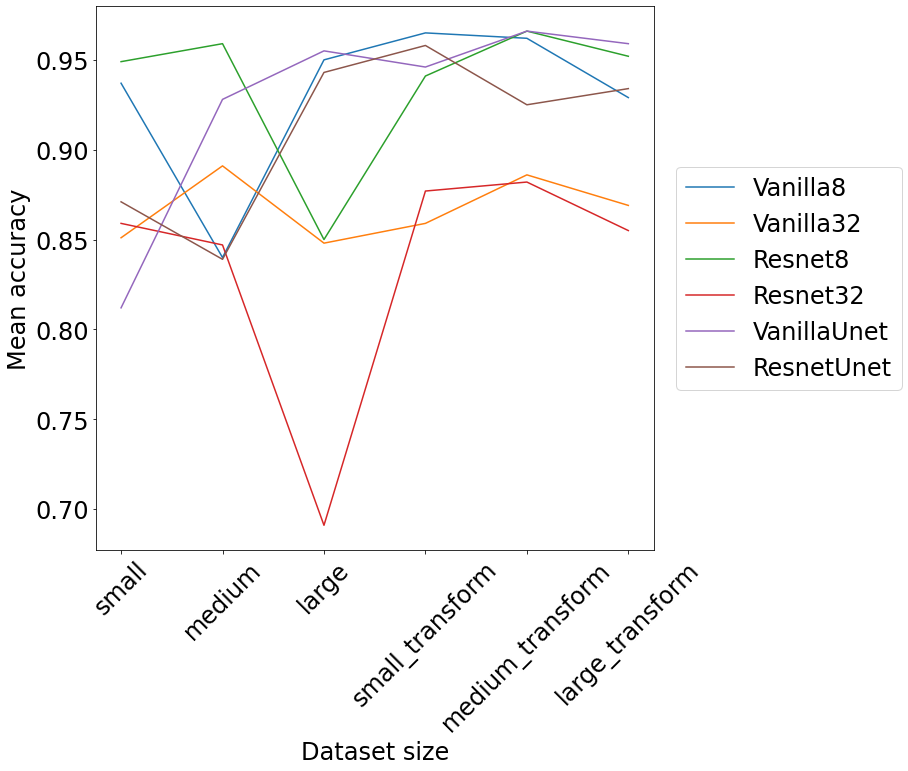

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='data_size', y='mean_acc', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
#ax.set(ylim=(0.95, 1))
plt.ylabel("Mean accuracy")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

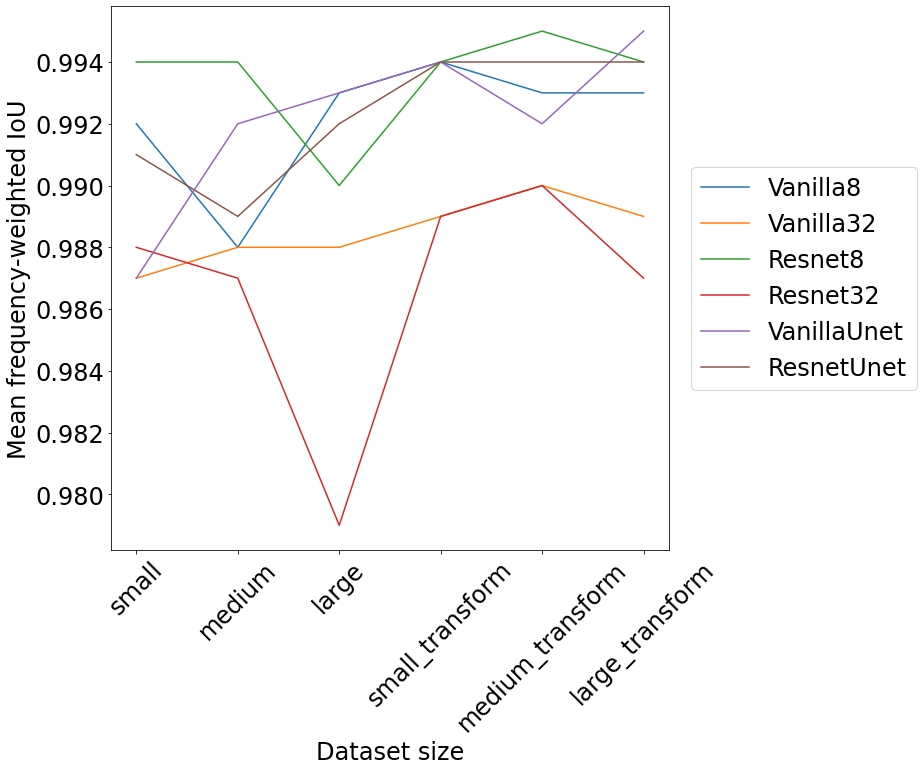

In [40]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='data_size', y='mean_F_iou', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
#ax.set(ylim=(0.95, 1))
plt.ylabel("Mean frequency-weighted IoU")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

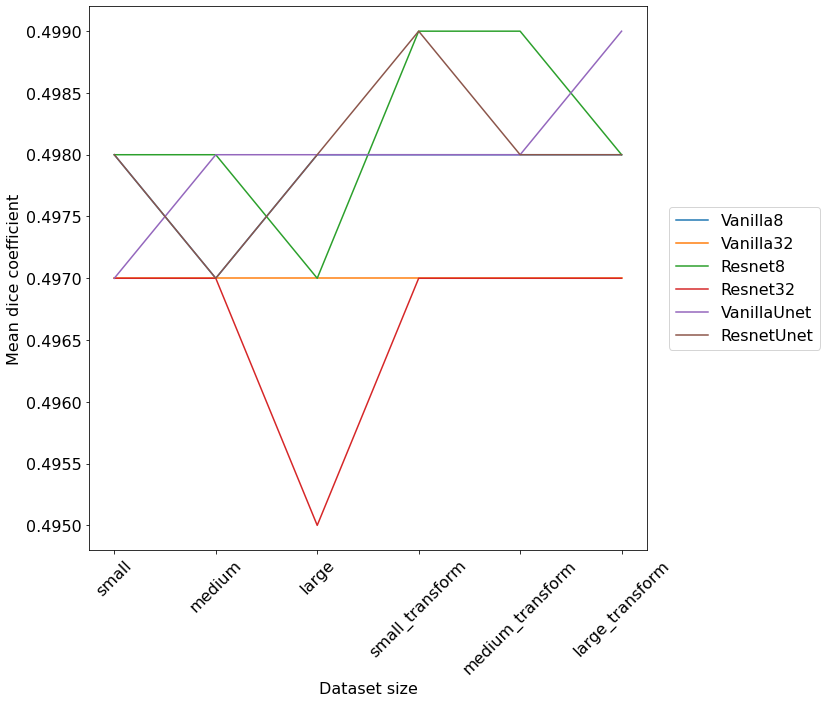

In [335]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='data_size', y='mean_dice', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
#ax.set(ylim=(0.95, 1))
plt.ylabel("Mean dice coefficient")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

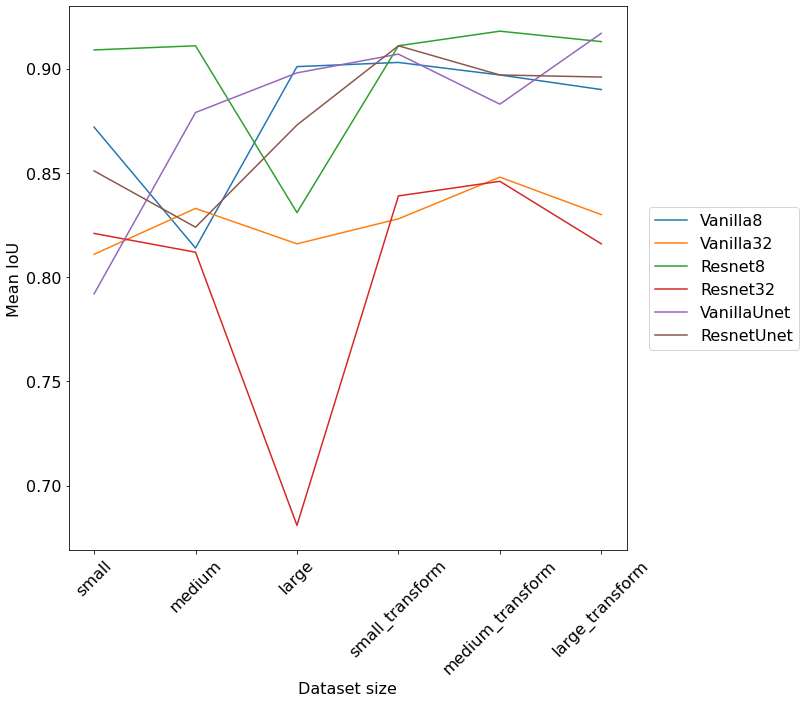

In [332]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='data_size', y='mean_iou', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
plt.ylabel("Mean IoU")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

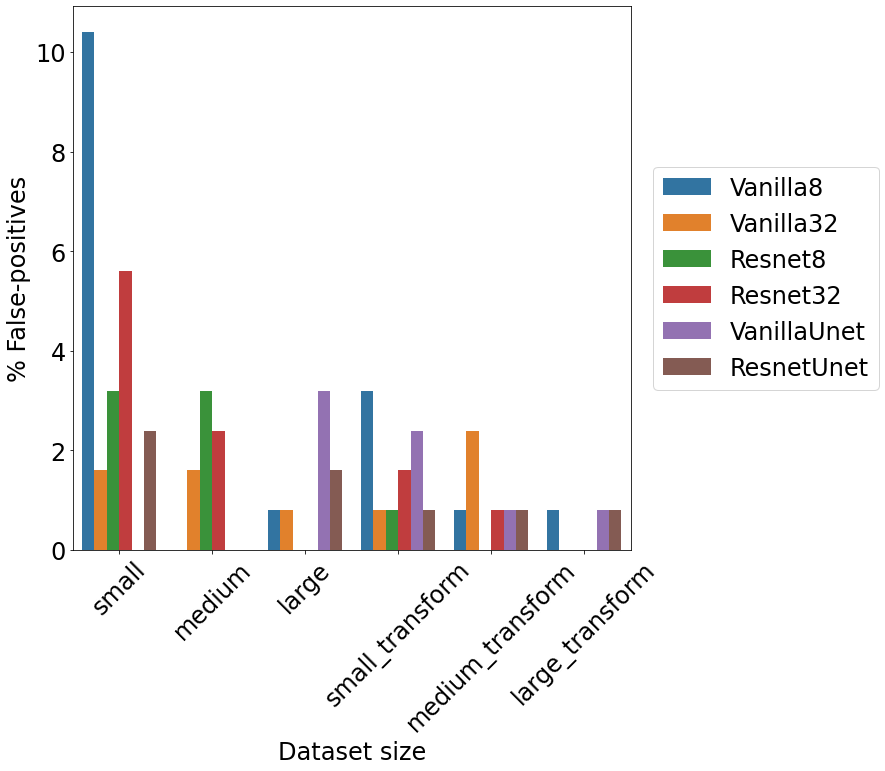

In [41]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x='data_size', y='perc_false_pos', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
plt.ylabel("% False-positives")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

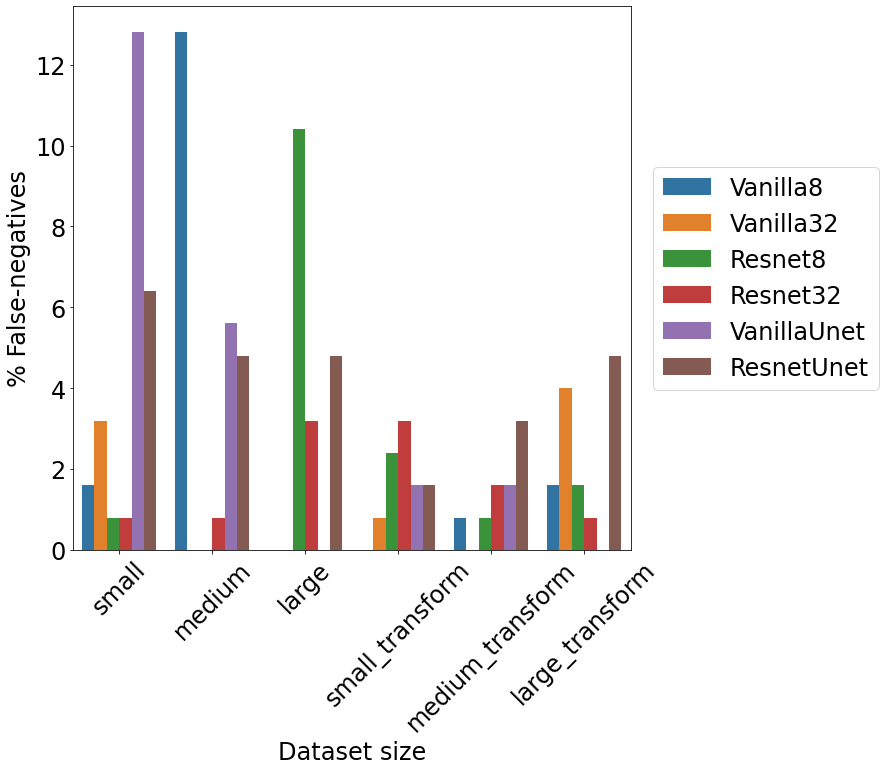

In [42]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x='data_size', y='perc_false_negs', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
plt.ylabel("% False-negatives")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

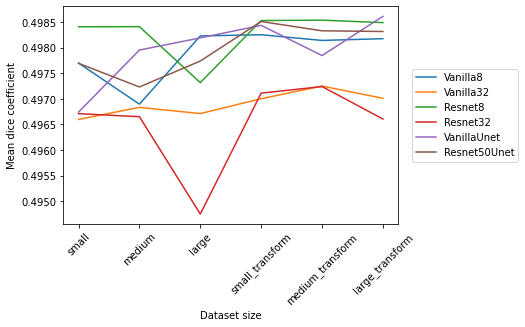

In [210]:
g3 = sns.lineplot(x='data_size', y='mean_dice', hue = 'model_name',
             data=model_df)
plt.xticks(rotation=45)
plt.ylabel("Mean dice coefficient")
plt.xlabel("Dataset size")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [228]:
k=1

# segmentation
seg = np.zeros((100,100), dtype='int')
seg[30:70, 30:70] = k

# ground truth
gt = np.zeros((100,100), dtype='int')
gt[30:70, 40:80] = k

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print('Dice similarity score is '+str(dice))

Dice similarity score is 0.75
